In [1]:
import torch, pickle
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
torch.cuda.is_available()

### accelerate huggingface to GPU

True

In [2]:
# data=pickle.load(open(f"data_len.pkl", 'rb'))
# data=pickle.load(open(f"data1.dat", 'rb'))
data=pickle.load(open(f"data.dat", 'rb'))

In [2]:
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Linear, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MessagePassing, global_mean_pool, norm, global_max_pool, global_add_pool

class GN(MessagePassing):
    def __init__(self, n_f, msg_dim, ndim, hidden=128, aggr='add'):
        super(GN, self).__init__(aggr=aggr)  # "Add" aggregation.
        self.msg_fnc = Seq(
            Lin(2*n_f, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
#             Lin(hidden, hidden),
#             ReLU(),
            ##(Can turn on or off this layer:)
#             Lin(hidden, hidden), 
#             ReLU(),
            Lin(hidden, msg_dim)
        )
        
        self.node_fnc = Seq(
            Lin(msg_dim+n_f, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
#             Lin(hidden, hidden),
#             ReLU(),
            Lin(hidden, ndim)
        )
    
    #[docs]
    def forward(self, x, edge_index):
        #x is [n, n_f]
        x = x
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
      
    def message(self, x_i, x_j):
        # x_i has shape [n_e, n_f]; x_j has shape [n_e, n_f]
        tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.msg_fnc(tmp)
    
    def update(self, aggr_out, x=None):
        # aggr_out has shape [n, msg_dim]

        tmp = torch.cat([x, aggr_out], dim=1)
        return self.node_fnc(tmp) #[n, nupdate]

In [20]:
class MP(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(MP, self).__init__()
        
        self.conv1 = op ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = op
        # Our final linear layer will define our output
#         self.bn = BatchNorm1d(num_features=hidden_channels) # layer_norm instead
        self.lin = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, batch)[0]
        print(x)
        x = x.relu()
        x = self.conv2(x, edge_index, batch) 

          # 2. Readout layer
#         x = global_max_pool(x, batch)  ## Miles says use sumpool
#         x = global_mean_pool(x, batch)
#         x=concat(x1,x2)
        x = global_add_pool(x, batch)  ## Miles says use sumpool

#         x = F.dropout(x, p=0.1, training=self.training)

        x = self.lin(x)

        return x
    
model = MP(hidden_channels=32)
model

MP(
  (conv1): MetaLayer(
      edge_model=None,
      node_model=<class '__main__.NodeModel'>,
      global_model=None
  )
  (conv2): MetaLayer(
      edge_model=None,
      node_model=<class '__main__.NodeModel'>,
      global_model=None
  )
  (lin): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
criterion = torch.nn.MSELoss()
batch_size=64
np.random.shuffle(data)
test_data=data[int(len(data)*0.7):]
train_data=data[:int(len(data)*0.7)]

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=1)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Initialize our train function
def train():
    model.train()
 
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
 # test function
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
#         print(out)
        correct += (abs(out - dat.y.view(-1,1))).sum() 
    return correct / len(loader.dataset) 
tr_acc, te_acc=[],[]

for epoch in range(100):
    train()
    
    if (epoch+1)%10==0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        tr_acc.append(train_acc)
        te_acc.append(test_acc)
        print(f'Epoch: {epoch+1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

(NodeModel(
  (node_mlp_1): Sequential(
    (0): Linear(in_features=47, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (node_mlp_2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=47, bias=True)
  )
), tensor([ 0,  0,  0,  ..., 63, 63, 63]), None)


AttributeError: 'tuple' object has no attribute 'relu'

In [152]:
ys, pred=[],[]
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader:  # Iterate in batches over the training/test dataset.
        out = model(dat.x, dat.edge_index, dat.batch) 
#         print(out.view(1,-1).detach().numpy())
        pred.append(out.view(1,-1).detach().numpy())
        ys.append(np.array(dat.y)) # Check against ground-truth labels.
#     return correct / len(loader.dataset)  # Derive ratio of correct predictions.
test(test_loader)
# test(train_loader)
ys=np.hstack(ys)
pred=np.hstack(pred)[0]

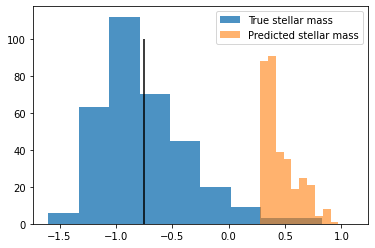

In [153]:
plt.hist(ys, range=(-1.6,1.1), bins=10, alpha=0.8, label='True stellar mass')
# plt.hist(pred, range=(-1.6,1.1), bins=10, alpha=0.6, label='Predicted stellar mass')
plt.hist(pred, bins=10, alpha=0.6, label='Predicted stellar mass')

plt.vlines(np.mean(ys), 0,100, 'k')
plt.legend()

[Text(0.5, 0, 'true'), Text(0, 0.5, 'predicted')]

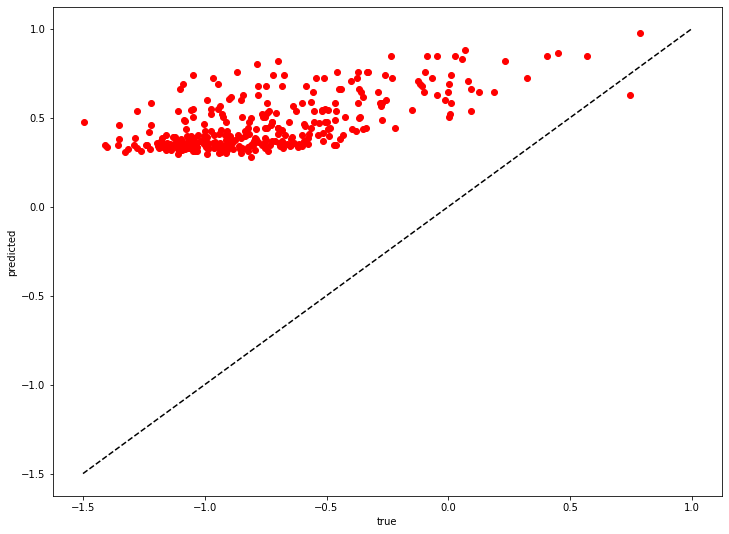

In [154]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(ys,pred, 'ro')
ax.plot([-1.5,1],[-1.5,1], 'k--')
ax.set(xlabel='true',ylabel='predicted')

In [31]:
x,y=[], []
for d in data:
    x.append(d.x[0,7].numpy())
    y.append(d.y.numpy())    

(array([524., 273., 139.,  76.,  40.,  20.,  11.,  10.,   3.,   3.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.000202 , 1.2101587, 1.4201155, 1.6300722, 1.840029 , 2.049986 ,
        2.2599425, 2.4698994, 2.679856 , 2.889813 , 3.0997696, 3.3097265,
        3.5196834, 3.72964  , 3.939597 , 4.149554 , 4.3595104, 4.569467 ,
        4.7794237, 4.989381 , 5.1993375], dtype=float32),
 <BarContainer object of 20 artists>)

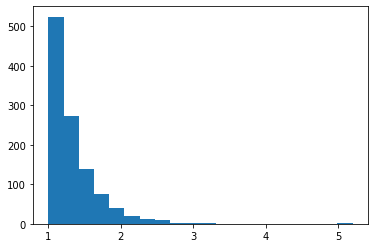

In [32]:
plt.hist(np.hstack(x), bins=20)

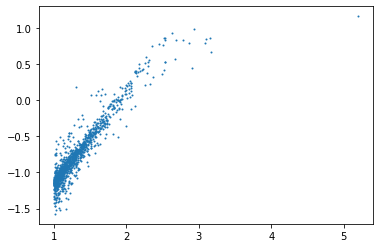

In [34]:
plt.plot(x, y, 'o', markersize=1)

In [ ]:
## remember to validate that test/val/train are actually comparable
## create toy problem (predict variance of all halo masses eg, verifying that in takes into account edges)
## same, predict average of the difference of post-merge halo and pre merger halos

## try different pools

In [11]:
a=1
if a is not None:
    a=2
a

2